In [78]:
#!pip install keras

In [79]:
#!pip install tqdm

In [80]:
#!pip install scikit-image

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet201

In [3]:
covid_class = ['COVID','non-COVID']
data_path = 'C:/Users/hyeji/Desktop/project/AI_project/COV_CT'
data_dir = os.path.join(data_path)

In [4]:
data = []
for c_id, sp in enumerate(covid_class):
    for file in os.listdir(os.path.join(data_dir,sp)):
        data.append(['{}/{}'.format(sp,file),c_id,sp])
        
data_list = pd.DataFrame(data,columns=['File','DiseaseID','Disease Type'])
data_list.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (1).png,0,COVID
1,COVID/Covid (10).png,0,COVID
2,COVID/Covid (100).png,0,COVID
3,COVID/Covid (1000).png,0,COVID
4,COVID/Covid (1001).png,0,COVID


In [5]:
data_list = data_list.sample(frac=1, random_state=42)
data_list.index = np.arange(len(data_list))
data_list.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (1227).png,0,COVID
1,COVID/Covid (430).png,0,COVID
2,non-COVID/Non-Covid (322).png,1,non-COVID
3,non-COVID/Non-Covid (379).png,1,non-COVID
4,COVID/Covid (609).png,0,COVID


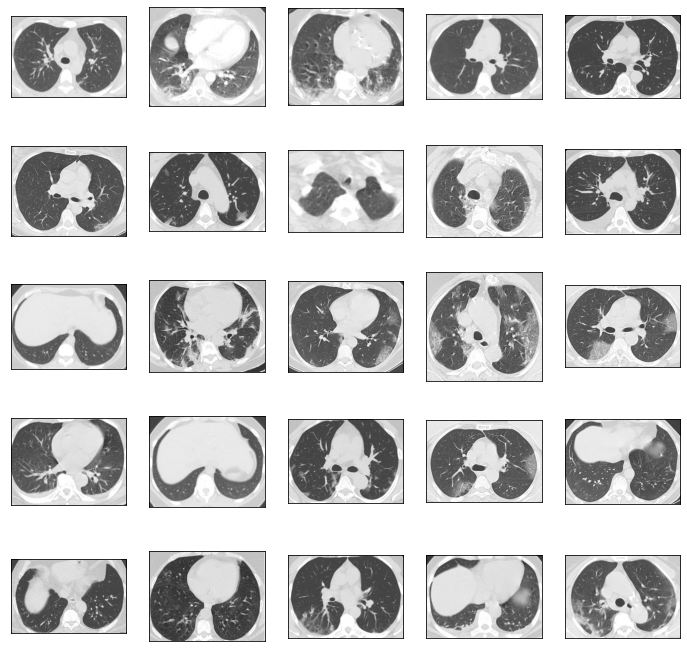

In [6]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = data_list['File'][data_list['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_path, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1

plot_defects('COVID', 5, 5)

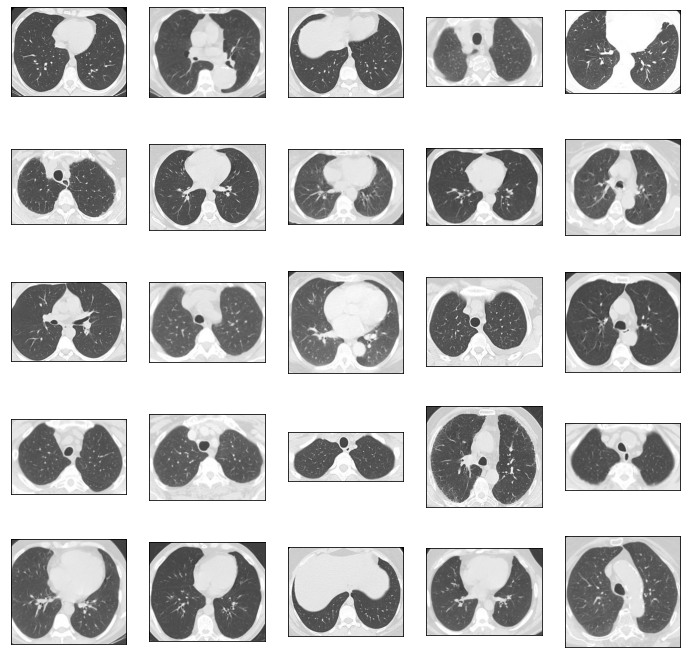

In [7]:
plot_defects('non-COVID', 5, 5)

In [8]:
IMAGE_SIZE = 64
def read_image(filepath):
    return cv2.imread(os.path.join(data_path, filepath)) 
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)


In [9]:
data_image = np.zeros((data_list.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(data_list['File'].values)):
    image = read_image(file)
    if image is not None:
        data_image[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

data_image = data_image / 255.
print('Train Shape: {}'.format(data_image.shape))

2481it [00:06, 389.85it/s]

Train Shape: (2481, 64, 64, 3)


In [10]:
data_title = data_list['DiseaseID'].values
data_title = to_categorical(data_title, num_classes=2)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data_image, data_title, test_size=0.2, random_state=42)

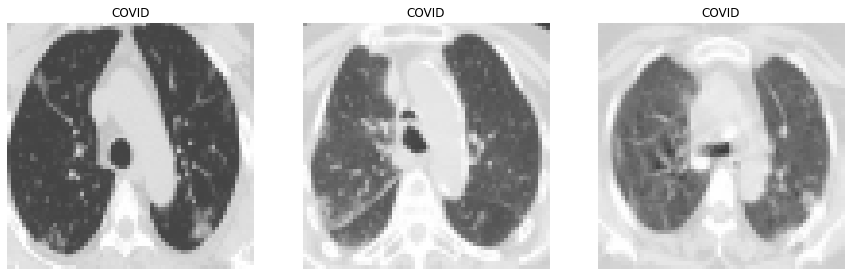

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(covid_class[np.argmax(y_train[i])])

In [18]:
def build_densenet():
    densenet = DenseNet201(weights='imagenet', include_top=False)

    input = Input(shape=(64, 64, 3))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    output = Dense(2,activation = 'softmax', name='root')(x)

    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [19]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('ct_model_dense201.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(rotation_range=20, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2, 
                        zoom_range=0.2,
                        horizontal_flip=True, 
                        vertical_flip=True) 

datagen.fit(X_train)


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         84        
_________________________________________________________________
densenet201 (Functional)     (None, None, None, 1920)  18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1920)              7680      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)              

In [21]:
BATCH_SIZE = 64
hist = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=30,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_test, y_test))

Epoch 1/30

Epoch 00001: val_loss improved from inf to 1.36103, saving model to ct_model_dense201.h5
31/31 - 104s - loss: 1.0634 - accuracy: 0.5988 - val_loss: 1.3610 - val_accuracy: 0.4487
Epoch 2/30

Epoch 00002: val_loss improved from 1.36103 to 1.22990, saving model to ct_model_dense201.h5
31/31 - 105s - loss: 0.9330 - accuracy: 0.6502 - val_loss: 1.2299 - val_accuracy: 0.4628
Epoch 3/30

Epoch 00003: val_loss did not improve from 1.22990
31/31 - 93s - loss: 0.7754 - accuracy: 0.6835 - val_loss: 1.6438 - val_accuracy: 0.4507
Epoch 4/30

Epoch 00004: val_loss did not improve from 1.22990
31/31 - 92s - loss: 0.6736 - accuracy: 0.7455 - val_loss: 1.7020 - val_accuracy: 0.4547
Epoch 5/30

Epoch 00005: val_loss did not improve from 1.22990
31/31 - 92s - loss: 0.6257 - accuracy: 0.7399 - val_loss: 1.2927 - val_accuracy: 0.5392
Epoch 6/30

Epoch 00006: val_loss improved from 1.22990 to 1.08228, saving model to ct_model_dense201.h5
31/31 - 93s - loss: 0.5417 - accuracy: 0.7898 - val_loss: 

In [42]:
model.save('COV_dense_v2.h5')

In [22]:
model.evaluate(X_test,y_test)

16/16 [==============================] - 4s 281ms/step - loss: 0.2268 - accuracy: 0.9095


[0.22675149142742157, 0.909456729888916]

Text(0.5, 145.31999999999996, 'Predicted')

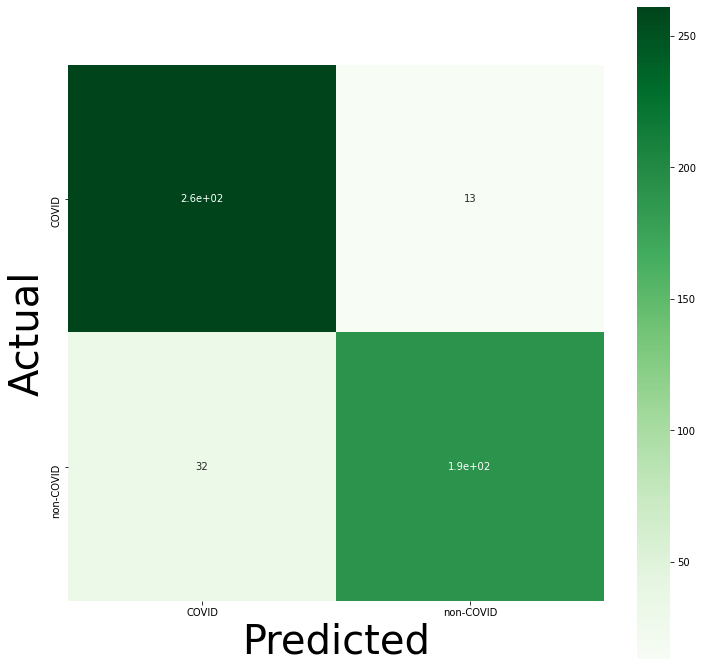

In [40]:
pred = model.predict(X_test)
# print(pred)
pred_1 = np.argmax(pred, axis=1)
true = np.argmax(y_test, axis=1)

cm = confusion_matrix(true, pred_1)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=covid_class, yticklabels=covid_class)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [41]:
print(pred)

[[9.98340964e-01 1.65896746e-03]
 [2.71370709e-01 7.28629231e-01]
 [7.21462129e-06 9.99992728e-01]
 [2.25728247e-02 9.77427125e-01]
 [9.70890462e-01 2.91095935e-02]
 [9.86771286e-01 1.32286390e-02]
 [9.95239854e-01 4.76018991e-03]
 [1.05497509e-01 8.94502521e-01]
 [4.91827279e-02 9.50817227e-01]
 [9.89555240e-01 1.04448060e-02]
 [1.00000000e+00 2.21223352e-11]
 [3.98585409e-01 6.01414502e-01]
 [8.46096218e-01 1.53903782e-01]
 [2.31149681e-02 9.76885080e-01]
 [9.99990344e-01 9.66720654e-06]
 [3.15842032e-01 6.84157908e-01]
 [9.68826652e-01 3.11733559e-02]
 [9.99778807e-01 2.21232374e-04]
 [8.13814282e-01 1.86185688e-01]
 [7.50053227e-01 2.49946773e-01]
 [4.62754995e-01 5.37245035e-01]
 [9.90935981e-01 9.06400476e-03]
 [3.34320247e-01 6.65679753e-01]
 [9.61375952e-01 3.86240855e-02]
 [9.11686048e-02 9.08831358e-01]
 [4.62228694e-04 9.99537826e-01]
 [1.31109753e-03 9.98688877e-01]
 [9.99998927e-01 1.11085387e-06]
 [9.89117682e-01 1.08823488e-02]
 [4.98104036e-01 5.01895964e-01]
 [1.154224

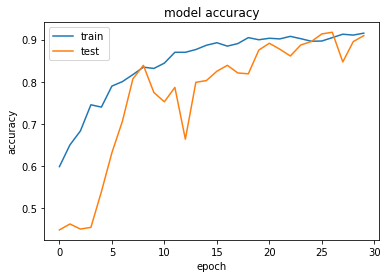

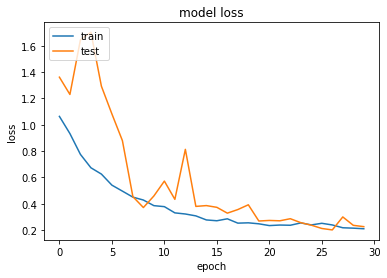

In [24]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

[0.00171356 0.9982864 ]


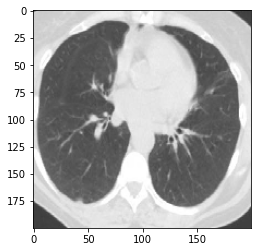

Prediction: Non Covid-19


In [39]:
from skimage import io
from keras.preprocessing import image

img = image.load_img(data_path+'/non-COVID/Non-Covid (355).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img(data_path+'/non-COVID/Non-Covid (355).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])

# 모델 불러오고 사용

In [43]:
loadmodel = load_model("COV_dense_v2.h5")

In [47]:
loadmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
loadmodel.evaluate(X_test,y_test)

16/16 [==============================] - 6s 360ms/step - loss: 0.2268 - accuracy: 0.9095


[0.22675149142742157, 0.909456729888916]

[0.02279887 0.9772011 ]


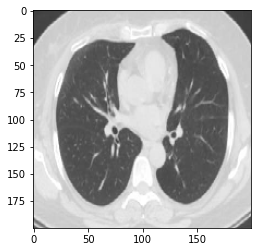

Prediction: Non Covid-19


In [46]:
from skimage import io
from keras.preprocessing import image

img = image.load_img(data_path+'/non-COVID/Non-Covid (123).png', grayscale=False, target_size=(64, 64))
show_img=image.load_img(data_path+'/non-COVID/Non-Covid (123).png', grayscale=False, target_size=(200, 200))
disease_class=['Covid-19','Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = loadmodel.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])